In [1]:
#!ls -al /content/drive/MyDrive/lab4
!nvidia-smi

Wed May 19 09:51:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchsummary import summary

from matplotlib import pyplot as plt
from scipy.io import loadmat
import math, sys, os, time
import pandas as pd
import numpy as np

DATASET_DIR = "/content/drive/MyDrive/AE-4-EEG-Artifact-Removal/BCICIV2a/"
BASE_DIR = "/content/drive/MyDrive/lab4/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch shape: (batch_size, chan (depth), h, w)

# EEG-model

In [2]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()

        self.F1 = 8
        self.F2 = 16
        self.D = 2

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(self.F1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.F1, self.D*self.F1, (22, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.D*self.F1),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(self.D*self.F1, self.D*self.F1, (1, 16), padding=(0, 8), groups=self.D*self.F1, bias=False),
            nn.Conv2d(self.D*self.F1, self.F2, (1, 1), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.5)
        )

        self.classifier = nn.Linear(16*17, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Conv3(x)
        
        x = x.view(-1, 16*17)
        x = self.classifier(x)
        #x = self.softmax(x)
        return x

In [3]:
class ShallowConvNet(nn.Module):
    def __init__(self):
        super(ShallowConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 40, (1, 13), bias=False)
        self.conv2 = nn.Conv2d(40, 40, (22, 1), bias=False)
        self.Bn1   = nn.BatchNorm2d(40)
        # self.SquareLayer = square_layer()
        self.AvgPool1 = nn.AvgPool2d((1, 35), stride=(1, 7))
        # self.LogLayer = Log_layer()
        self.Drop1 = nn.Dropout(0.25)
        self.classifier = nn.Linear(40*74, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Bn1(x)
        x = x ** 2
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = self.Drop1(x)
        x = x.view(-1, 40*74)
        x = self.classifier(x)

        #x = self.softmax(x)
        return x

In [4]:
class SCCNet(nn.Module):
    def __init__(self):
        super(SCCNet, self).__init__()
        # bs, 1, channel, sample
        self.conv1 = nn.Conv2d(1, 22, (22, 1))
        self.Bn1 = nn.BatchNorm2d(22)
        # bs, 22, 1, sample
        self.conv2 = nn.Conv2d(22, 20, (1, 12), padding=(0, 6))
        self.Bn2   = nn.BatchNorm2d(20)
        # self.SquareLayer = square_layer()
        self.Drop1 = nn.Dropout(0.5)
        self.AvgPool1 = nn.AvgPool2d((1, 62), stride=(1, 12))
        self.classifier = nn.Linear(840, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.Bn1(x)
        x = self.conv2(x)
        x = self.Bn2(x)
        x = x ** 2
        x = self.Drop1(x)
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = x.view(-1, 840)
        x = self.classifier(x)

        #x = self.softmax(x)
        return x

In [5]:
class TSception(nn.Module):
    def conv_block(self, in_chan, out_chan, kernel, step, pool):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_chan, out_channels=out_chan,
                      kernel_size=kernel, stride=step, padding=0),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(1, pool), stride=(1, pool)))

    def __init__(self, num_classes, input_size, sampling_rate, num_T, num_S, hidden, dropout_rate):
        # input_size: 1 x EEG channel x datapoint
        super(TSception, self).__init__()
        self.inception_window = [0.5, 0.25, 0.125]
        self.pool = 8
        # by setting the convolutional kernel being (1,lenght) and the strids being 1 we can use conv2d to
        # achieve the 1d convolution operation
        self.Tception1 = self.conv_block(1, num_T, (1, int(self.inception_window[0] * sampling_rate)), 1, self.pool)
        self.Tception2 = self.conv_block(1, num_T, (1, int(self.inception_window[1] * sampling_rate)), 1, self.pool)
        self.Tception3 = self.conv_block(1, num_T, (1, int(self.inception_window[2] * sampling_rate)), 1, self.pool)

        self.Sception1 = self.conv_block(num_T, num_S, (int(input_size[1]), 1), 1, int(self.pool*0.25))
        self.Sception2 = self.conv_block(num_T, num_S, (int(input_size[1] * 0.5), 1), (int(input_size[1] * 0.5), 1),
                                         int(self.pool*0.25))
        self.fusion_layer = self.conv_block(num_S, num_S, (3, 1), 1, 2)
        self.BN_t = nn.BatchNorm2d(num_T)
        self.BN_s = nn.BatchNorm2d(num_S)
        self.BN_fusion = nn.BatchNorm2d(num_S)

        size = self.get_size(input_size)
        self.fc = nn.Sequential(
            nn.Linear(size[1], hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        y = self.Tception1(x)
        out = y
        y = self.Tception2(x)
        out = torch.cat((out, y), dim=-1)
        y = self.Tception3(x)
        out = torch.cat((out, y), dim=-1)
        out = self.BN_t(out)
        z = self.Sception1(out)
        out_ = z
        z = self.Sception2(out)
        out_ = torch.cat((out_, z), dim=2)

        out = self.BN_s(out_)
        out = self.fusion_layer(out)
        out = self.BN_fusion(out)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

    def get_size(self, input_size):
        # here we use an array with the shape being
        # (1(mini-batch),1(convolutional channel),EEG channel,time data point)
        # to simulate the input data and get the output size
        data = torch.ones((1, input_size[0], input_size[1], int(input_size[2])))
        y = self.Tception1(data)
        out = y
        y = self.Tception2(data)
        out = torch.cat((out, y), dim=-1)
        y = self.Tception3(data)
        out = torch.cat((out, y), dim=-1)
        out = self.BN_t(out)
        z = self.Sception1(out)
        out_final = z
        z = self.Sception2(out)
        out_final = torch.cat((out_final, z), dim=2)
        out = self.BN_s(out_final)
        out = self.fusion_layer(out)
        out = self.BN_fusion(out)
        out = out.view(out.size()[0], -1)
        return out.size()

# Model Utilities & some function

In [6]:
class Model(object):
    def __init__(self, model=None, lr=0.001):
        super(Model, self).__init__()
        self.model = model
        self.losses = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
    def fit(self, trainloader=None, validloader=None, epochs=1, monitor=None, verbose=1):
        doValid = False if validloader == None else True
        pre_ck_point = [float("inf"), 0.0, float("inf"), 0.0, 0] # loss, acc, val_loss, val_acc, epoch
        history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}
        for ep in range(1, epochs + 1):
            proc_start = time.time() # timer start
            if ((not (ep % 10)) or (ep == 1)) and verbose != 0:
                print(f"Epoch {ep}/{epochs}")
            self.model.train()
            step = 1
            for x_batch, y_batch in trainloader:
                x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
                pred = self.model(x_batch)
                loss = self.losses(pred, y_batch)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                if ((not (ep % 10)) or (ep == 1)) and verbose != 0:
                    pbar = int(step * 30 / len(trainloader))
                    print("\r{}/{} [{}{}]".format(
                        step, len(trainloader), ">" * pbar, " " * (30 - pbar)), 
                        end="")
                step += 1
            # evaluate
            loss, acc = self.evaluate(trainloader)
            val_loss, val_acc = self.evaluate(validloader) if doValid else (0, 0)
            history["loss"] = np.append(history["loss"], loss)
            history["acc"] = np.append(history["acc"], acc)
            history["val_loss"] = np.append(history["val_loss"], val_loss)
            history["val_acc"] = np.append(history["val_acc"], val_acc)
            # dump message
            if ((not (ep % 10)) or (ep == 1)) and verbose != 0:
                print(" {:.4f}s - loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}".format(
                    time.time()-proc_start, history["loss"][-1], 
                    history["acc"][-1], history["val_loss"][-1], history["val_acc"][-1])
                )
            # model check point
            if self.__updateCheckpoint(monitor, pre_ck_point, [loss, acc, val_loss, val_acc, ep]):
                if not os.path.exists("./model"):
                    os.mkdir("./model")
                model_name = f"model/checkpoint_model_ep-{ep}.pt"
                self.save(model_name)
                history["lastest_model_path"] = model_name
                pre_ck_point = [loss, acc, val_loss, val_acc, ep]
        return history
    def evaluate(self, dataloader):
        total, acc = 0, 0
        self.model.eval()
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
            pred = self.model(x_batch)
            loss = self.losses(pred, y_batch).item()
            total += y_batch.shape[0]
            acc += (torch.sum(pred.argmax(dim=1)==y_batch)).item()
        acc /= total

        return (loss, acc)
    def predict(self, dataset, batch_size=128):
        dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
        prediction = []
        self.model.eval()
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
            pred = self.model(x_batch).cpu()
            prediction = np.append(prediction, pred.argmax(dim=1).numpy())
        return prediction.astype("uint8")
    def save(self, filepath):
        torch.save(self.model, filepath)
    @classmethod
    def load(cls, filepath):
        return cls(torch.load(filepath))
    def __updateCheckpoint(self, monitor, pre_ck_point, evaluation):
        if type(monitor) is int:
            return True if evaluation[4] % monitor == 0 else False
        elif type(monitor) is list:
            for _ in monitor:
                if not _ in ["loss", "acc", "val_loss", "val_acc"]:
                    raise Exception(f"\"{_}\" is not a valid monitor condition.")
                elif _ == "loss" and pre_ck_point[0] < evaluation[0]:
                    return False # present epoch loss > history loss
                elif _ == "acc" and pre_ck_point[1] > evaluation[1]:
                    return False # present epoch acc < history acc
                elif _ == "val_loss" and pre_ck_point[2] < evaluation[2]:
                    return False # present epoch val_loss > history val_loss
                elif _ == "val_acc" and pre_ck_point[3] > evaluation[3]:
                    return False # present epoch val_acc < history val_acc        
        return True

In [7]:
def plot_confusion_matrix(conf_matrix, title="Confusion Matrix"):
    plt.figure(figsize=(10, 10))
    plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xticks([0,1,2,3], [0,1,2,3], rotation=45)
    plt.yticks([0,1,2,3], [0,1,2,3])

    thresh = conf_matrix.max() / 2.
    for i in range(4):
        for j in range(4):
            plt.text(j, i, format(conf_matrix[i, j], "d"), 
                horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("Real label")
    plt.xlabel("Pred label")
    plt.show()

#Part 1

## Problem 1

In [ ]:
BATCH_SIZE = 32
Learning_Rate = 0.001
EPOCHS = 500

In [ ]:
train_raw = loadmat(DATASET_DIR + "BCIC_S01_T.mat")
test_raw = loadmat(DATASET_DIR + "BCIC_S01_E.mat")
trX, trY, teX, teY = train_raw["x_train"], train_raw["y_train"], test_raw["x_test"], test_raw["y_test"]

In [ ]:
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
x_test = torch.from_numpy(np.expand_dims(teX, axis=1))
y_test = torch.from_numpy(np.reshape(teY, (teY.size, ))).long()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
trainset, testset = TensorDataset(x_train, y_train), TensorDataset(x_test, y_test)

""" create dataloader """
trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([288, 1, 22, 562]) torch.Size([288])
torch.Size([288, 1, 22, 562]) torch.Size([288])


Epoch 1/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2119s - loss: 1.3791 - acc: 0.2812 - val_loss: 1.3910 - val_acc: 0.2500
Epoch 10/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2036s - loss: 0.9965 - acc: 0.5799 - val_loss: 1.0180 - val_acc: 0.4757
Epoch 20/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2027s - loss: 0.7497 - acc: 0.6840 - val_loss: 0.9513 - val_acc: 0.5660
Epoch 30/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2123s - loss: 0.6505 - acc: 0.7535 - val_loss: 0.7895 - val_acc: 0.6319
Epoch 40/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1955s - loss: 0.6266 - acc: 0.8160 - val_loss: 0.7247 - val_acc: 0.6667
Epoch 50/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1968s - loss: 0.3396 - acc: 0.8472 - val_loss: 0.5205 - val_acc: 0.6806
Epoch 60/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2068s - loss: 0.3886 - acc: 0.8715 - val_loss: 0.4691 - val_acc: 0.7292
Epoch 70/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2025s - loss: 0.3164 - acc: 0.8785 - val_loss: 0.5561 - val_acc: 0.7361
Epoch 80/

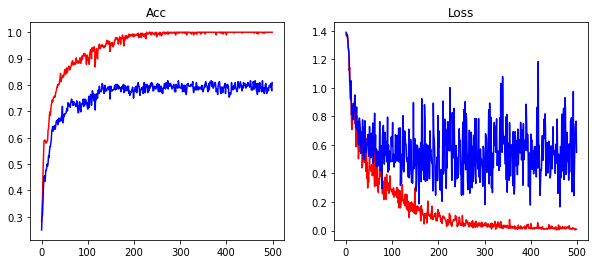

In [ ]:
eegnet = EEGNet().to(device)
#summary(eegnet, (1, 22, 562))
model = Model(eegnet, lr=Learning_Rate)
# save checkpoint model when both trainset and validset get new max acc
history = model.fit(trainloader=trainloader, validloader=testloader, epochs=EPOCHS, monitor=["acc", "val_acc"])

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(history["acc"], color="red")
plt.plot(history["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(history["loss"], color="red")
plt.plot(history["val_loss"], color="blue")
plt.show()

### (a)

In [ ]:
# load model
ld_model = Model.load(history["lastest_model_path"])
eva_train = ld_model.evaluate(dataloader=trainloader)
print(f"Train Accuracy: {eva_train[1]:.4f}\tTrain Loss: {eva_train[0]:.4f}")
eva_test = ld_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")

Train Accuracy: 1.0000	Train Loss: 0.0111
Test Accuracy: 0.8160	Test Loss: 1.2120


### (b)

In [ ]:
rec_train = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
# confusion matrix in (c)
conf_matrix_train = np.zeros(shape=(4, 4), dtype="uint8")
conf_matrix_test = np.zeros(shape=(4, 4), dtype="uint8")

real_train = trY.reshape(trY.size)
real_test = teY.reshape(teY.size)
pred_train = ld_model.predict(dataset=trainset)
pred_test = ld_model.predict(dataset=testset)

for i in range(288):
    rec_train["total"][real_train[i]] += 1
    rec_train["hit"][real_train[i]] += (1 if real_train[i] == pred_train[i] else 0)
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)

    conf_matrix_train[real_train[i]][pred_train[i]] += 1
    conf_matrix_test[real_test[i]][pred_test[i]] += 1

In [ ]:
for i in range(4):
    print("Train accuracy of class-{}: {}".format(i, rec_train["hit"][i] / rec_train["total"][i]))
print()
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))

Train accuracy of class-0: 1.0
Train accuracy of class-1: 1.0
Train accuracy of class-2: 1.0
Train accuracy of class-3: 1.0

Test accuracy of class-0: 0.8194444444444444
Test accuracy of class-1: 0.9861111111111112
Test accuracy of class-2: 0.7638888888888888
Test accuracy of class-3: 0.6944444444444444


### (c)

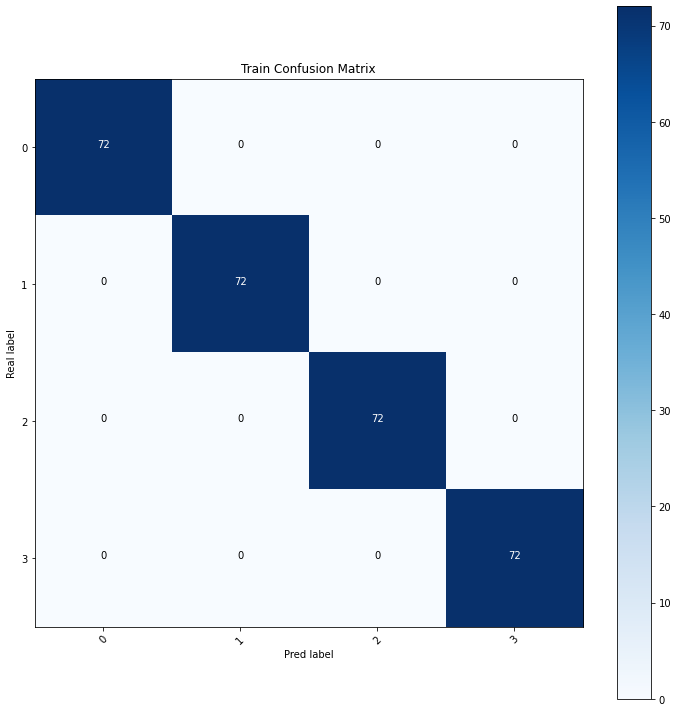

In [ ]:
#print(conf_matrix_train)
plot_confusion_matrix(conf_matrix_train, "Train Confusion Matrix")

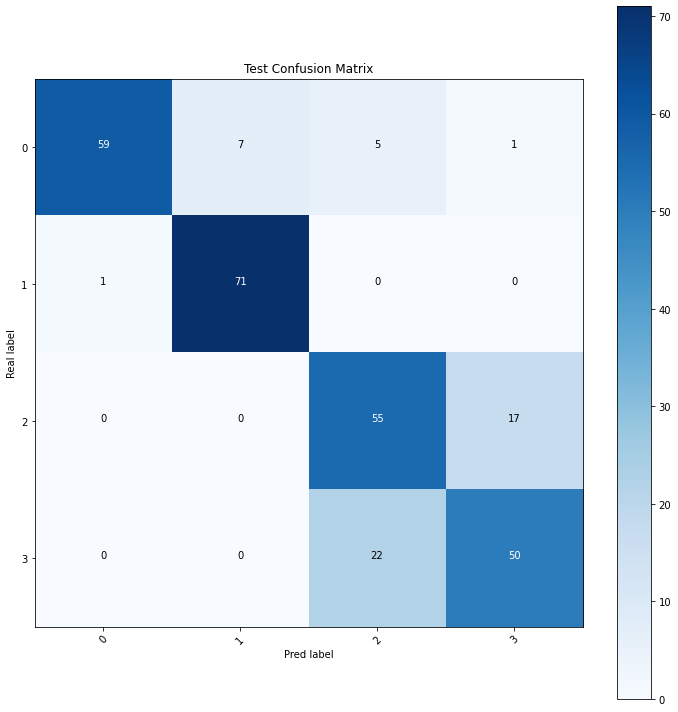

In [ ]:
#print(conf_matrix_test)
plot_confusion_matrix(conf_matrix_test, "Test Confusion Matrix")

## Problem 2

In [11]:
train_raw = loadmat(DATASET_DIR + "BCIC_S01_T.mat")
test_raw = loadmat(DATASET_DIR + "BCIC_S01_E.mat")
trX, trY, teX, teY = train_raw["x_train"], train_raw["y_train"], test_raw["x_test"], test_raw["y_test"]
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
x_test = torch.from_numpy(np.expand_dims(teX, axis=1))
y_test = torch.from_numpy(np.reshape(teY, (teY.size, ))).long()
trainset, testset = TensorDataset(x_train, y_train), TensorDataset(x_test, y_test)

In [ ]:
eegnet = EEGNet().to(device)
#ld_models = {}
for lr in [0.003, 0.001, 0.0003, 0.0001]:
    #best_models = {}
    for bs in [64, 32, 8, 2]:
        print(f"Process at learninr rate: {lr}, batch size: {bs}")
        trainloader = DataLoader(dataset=trainset, batch_size=bs, shuffle=True)
        testloader = DataLoader(dataset=testset, batch_size=bs, shuffle=True)
        model = Model(eegnet, lr=lr)
        history = model.fit(trainloader=trainloader, validloader=testloader, 
            epochs=500, monitor=["acc", "val_acc"], verbose=0)
        best_model = Model.load(history["lastest_model_path"])
        best_model.save(f"/content/drive/MyDrive/lab4/model/bs-{bs}_lr-{lr}_model.pt")
        #best_models[bs] = Model.load(history["lastest_model_path"])
    #ld_models[lr] = best_models

Process at learninr rate: 0.003, batch size: 64
Process at learninr rate: 0.003, batch size: 32
Process at learninr rate: 0.003, batch size: 8
Process at learninr rate: 0.003, batch size: 2
Process at learninr rate: 0.001, batch size: 64
Process at learninr rate: 0.001, batch size: 32
Process at learninr rate: 0.001, batch size: 8
Process at learninr rate: 0.001, batch size: 2
Process at learninr rate: 0.0003, batch size: 64
Process at learninr rate: 0.0003, batch size: 32
Process at learninr rate: 0.0003, batch size: 8
Process at learninr rate: 0.0003, batch size: 2
Process at learninr rate: 0.0001, batch size: 64
Process at learninr rate: 0.0001, batch size: 32
Process at learninr rate: 0.0001, batch size: 8
Process at learninr rate: 0.0001, batch size: 2


In [12]:
for lr in [0.003, 0.001, 0.0003, 0.0001]:
    for bs in [64, 32, 8, 2]:
        ld_model = Model.load(f"/content/drive/MyDrive/lab4/model/bs-{bs}_lr-{lr}_model.pt")
        testloader = DataLoader(dataset=testset, batch_size=bs, shuffle=True)
        eva_test = ld_model.evaluate(dataloader=testloader)
        print(f"Test Accuracy of lr={lr}, batch_size={bs}: {eva_test[1]:.4f}")

Test Accuracy of lr=0.003, batch_size=64: 0.8507
Test Accuracy of lr=0.003, batch_size=32: 0.8472
Test Accuracy of lr=0.003, batch_size=8: 0.8507
Test Accuracy of lr=0.003, batch_size=2: 0.7951
Test Accuracy of lr=0.001, batch_size=64: 0.8194
Test Accuracy of lr=0.001, batch_size=32: 0.8403
Test Accuracy of lr=0.001, batch_size=8: 0.8507
Test Accuracy of lr=0.001, batch_size=2: 0.8229
Test Accuracy of lr=0.0003, batch_size=64: 0.8194
Test Accuracy of lr=0.0003, batch_size=32: 0.8333
Test Accuracy of lr=0.0003, batch_size=8: 0.8438
Test Accuracy of lr=0.0003, batch_size=2: 0.8368
Test Accuracy of lr=0.0001, batch_size=64: 0.8194
Test Accuracy of lr=0.0001, batch_size=32: 0.8194
Test Accuracy of lr=0.0001, batch_size=8: 0.8264
Test Accuracy of lr=0.0001, batch_size=2: 0.8368


## Problem 3

In [9]:
train_raw_set = [loadmat(DATASET_DIR + f"BCIC_S0{i}_T.mat") for i in range(1, 10)]
test_raw_set = [loadmat(DATASET_DIR + f"BCIC_S0{i}_E.mat") for i in range(1, 10)]

eegnet = EEGNet().to(device)

### SI

In [10]:
trX, trY = np.empty((0, 22, 562)), np.empty((0, 1))
teX, teY = test_raw_set[0]["x_test"], test_raw_set[0]["y_test"]
for i in range(1, 9):
    trX = np.vstack([trX, train_raw_set[i]["x_train"]])
    trX = np.vstack([trX, test_raw_set[i]["x_test"]])
    trY = np.vstack([trY, train_raw_set[i]["y_train"]])
    trY = np.vstack([trY, test_raw_set[i]["y_test"]])
#print(trX.shape, trY.shape, teX.shape, teY.shape)
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
x_test = torch.from_numpy(np.expand_dims(teX, axis=1))
y_test = torch.from_numpy(np.reshape(teY, (teY.size, ))).long()
trainset, testset = TensorDataset(x_train, y_train), TensorDataset(x_test, y_test)
trainloader = DataLoader(dataset=trainset, batch_size=64, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=64, shuffle=True)

Epoch 1/500
72/72 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.4395s - loss: 1.3653 - acc: 0.2928 - val_loss: 1.3802 - val_acc: 0.3646
Epoch 10/500
72/72 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0079s - loss: 1.1973 - acc: 0.5221 - val_loss: 0.9550 - val_acc: 0.7014
Epoch 20/500
72/72 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0072s - loss: 1.0742 - acc: 0.5512 - val_loss: 0.9671 - val_acc: 0.6458
Epoch 30/500
72/72 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0161s - loss: 0.9526 - acc: 0.5872 - val_loss: 0.8807 - val_acc: 0.6215
Epoch 40/500
72/72 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0210s - loss: 0.9227 - acc: 0.6061 - val_loss: 0.9498 - val_acc: 0.6111
Epoch 50/500
72/72 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0339s - loss: 0.9554 - acc: 0.6094 - val_loss: 0.7995 - val_acc: 0.6250
Epoch 60/500
72/72 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0340s - loss: 1.0056 - acc: 0.6170 - val_loss: 0.9289 - val_acc: 0.6215
Epoch 70/500
72/72 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0511s - loss: 0.8440 - acc: 0.6434 - val_loss: 0.9074 - val_acc: 

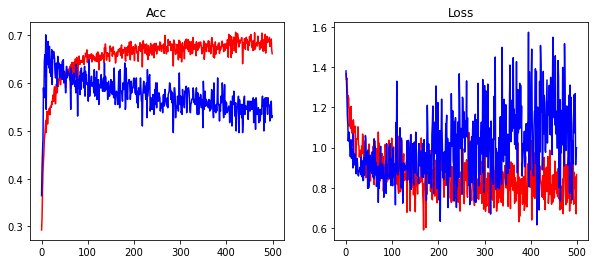

In [11]:
model = Model(eegnet, lr=0.001)
# save checkpoint model when both trainset and validset get new max acc
history = model.fit(trainloader=trainloader, validloader=testloader, epochs=500, monitor=["acc", "val_acc"])

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(history["acc"], color="red")
plt.plot(history["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(history["loss"], color="red")
plt.plot(history["val_loss"], color="blue")
plt.show()

Test Accuracy: 0.7014	Test Loss: 0.9979
Test accuracy of class-0: 0.875
Test accuracy of class-1: 0.75
Test accuracy of class-2: 0.4861111111111111
Test accuracy of class-3: 0.6944444444444444


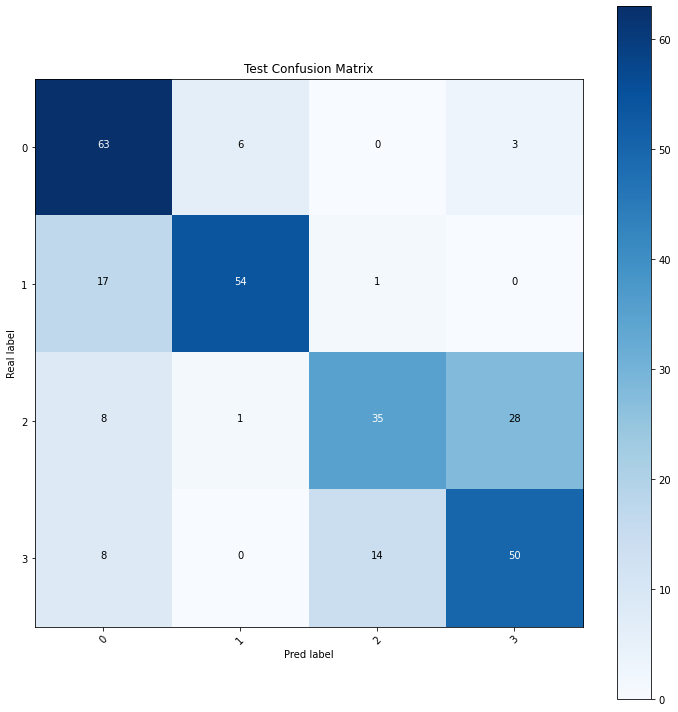

In [16]:
# load model
ld_model = Model.load(history["lastest_model_path"])
eva_test = ld_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
conf_matrix_test = np.zeros(shape=(4, 4), dtype="uint8")

real_test = teY.reshape(teY.size)
pred_test = ld_model.predict(dataset=testset)
for i in range(real_test.size):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
    conf_matrix_test[real_test[i]][pred_test[i]] += 1
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))
plot_confusion_matrix(conf_matrix_test, "Test Confusion Matrix")

### SD

In [10]:
trX, trY = np.empty((0, 22, 562)), np.empty((0, 1))
teX, teY = test_raw_set[0]["x_test"], test_raw_set[0]["y_test"]
for i in range(1, 9):
    trX = np.vstack([trX, train_raw_set[i]["x_train"]])
    trX = np.vstack([trX, test_raw_set[i]["x_test"]])
    trY = np.vstack([trY, train_raw_set[i]["y_train"]])
    trY = np.vstack([trY, test_raw_set[i]["y_test"]])
trX = np.vstack([trX, train_raw_set[0]["x_train"]])
trY = np.vstack([trY, train_raw_set[0]["y_train"]])
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
x_test = torch.from_numpy(np.expand_dims(teX, axis=1))
y_test = torch.from_numpy(np.reshape(teY, (teY.size, ))).long()
trainset, testset = TensorDataset(x_train, y_train), TensorDataset(x_test, y_test)
trainloader = DataLoader(dataset=trainset, batch_size=64, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=64, shuffle=True)

Epoch 1/500
77/77 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.5495s - loss: 1.3612 - acc: 0.3170 - val_loss: 1.3515 - val_acc: 0.3229
Epoch 10/500
77/77 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0912s - loss: 1.1692 - acc: 0.5339 - val_loss: 0.8851 - val_acc: 0.6840
Epoch 20/500
77/77 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0782s - loss: 1.1196 - acc: 0.5576 - val_loss: 0.8170 - val_acc: 0.7118
Epoch 30/500
77/77 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1081s - loss: 1.0529 - acc: 0.5984 - val_loss: 0.7975 - val_acc: 0.6979
Epoch 40/500
77/77 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1112s - loss: 1.0295 - acc: 0.6127 - val_loss: 0.7855 - val_acc: 0.6840
Epoch 50/500
77/77 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1096s - loss: 1.0375 - acc: 0.6203 - val_loss: 0.7904 - val_acc: 0.6875
Epoch 60/500
77/77 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1010s - loss: 0.8377 - acc: 0.6174 - val_loss: 0.6726 - val_acc: 0.7188
Epoch 70/500
77/77 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1218s - loss: 0.7242 - acc: 0.6293 - val_loss: 0.6888 - val_acc: 

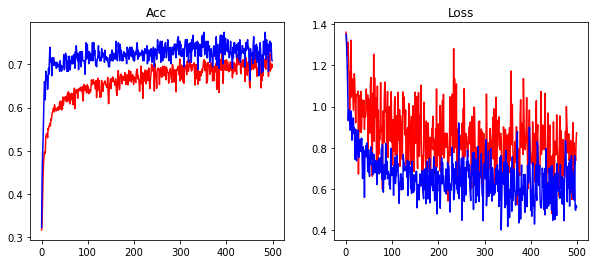

In [11]:
model = Model(eegnet, lr=0.001)
# save checkpoint model when both trainset and validset get new max acc
history = model.fit(trainloader=trainloader, validloader=testloader, epochs=500, monitor=["acc", "val_acc"])

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(history["acc"], color="red")
plt.plot(history["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(history["loss"], color="red")
plt.plot(history["val_loss"], color="blue")
plt.show()

Test Accuracy: 0.7743	Test Loss: 0.5483
Test accuracy of class-0: 0.9027777777777778
Test accuracy of class-1: 0.9583333333333334
Test accuracy of class-2: 0.8472222222222222
Test accuracy of class-3: 0.3888888888888889


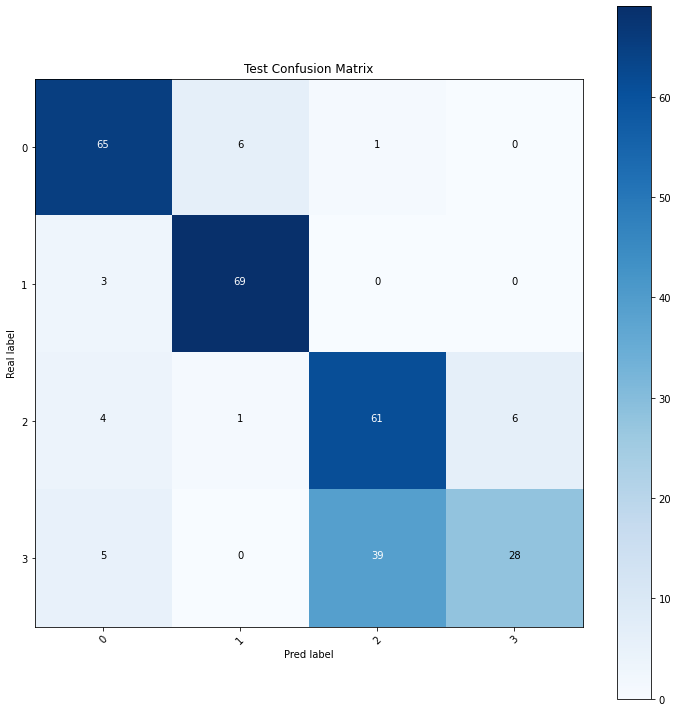

In [12]:
# load model
ld_model = Model.load(history["lastest_model_path"])
eva_test = ld_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
conf_matrix_test = np.zeros(shape=(4, 4), dtype="uint8")

real_test = teY.reshape(teY.size)
pred_test = ld_model.predict(dataset=testset)
for i in range(real_test.size):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
    conf_matrix_test[real_test[i]][pred_test[i]] += 1
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))
plot_confusion_matrix(conf_matrix_test, "Test Confusion Matrix")

### SI + FT

In [31]:
trX, trY = np.empty((0, 22, 562)), np.empty((0, 1))
teX, teY = test_raw_set[0]["x_test"], test_raw_set[0]["y_test"]
for i in range(1, 9):
    trX = np.vstack([trX, train_raw_set[i]["x_train"]])
    trX = np.vstack([trX, test_raw_set[i]["x_test"]])
    trY = np.vstack([trY, train_raw_set[i]["y_train"]])
    trY = np.vstack([trY, test_raw_set[i]["y_test"]])
#print(trX.shape, trY.shape, teX.shape, teY.shape)
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
x_test = torch.from_numpy(np.expand_dims(teX, axis=1))
y_test = torch.from_numpy(np.reshape(teY, (teY.size, ))).long()
trainset, testset = TensorDataset(x_train, y_train), TensorDataset(x_test, y_test)
trainloader = DataLoader(dataset=trainset, batch_size=64, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=64, shuffle=True)

In [32]:
model = Model(eegnet, lr=0.001)
# save checkpoint model when both trainset and validset get new max acc
history = model.fit(trainloader=trainloader, validloader=testloader, epochs=500, monitor=["acc", "val_acc"])
# save pre-trained model
ld_model = Model.load(history["lastest_model_path"])
ld_model.save("./model/pre-trained_si_model.pt")

Epoch 1/500
72/72 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1575s - loss: 0.7297 - acc: 0.7413 - val_loss: 1.0037 - val_acc: 0.6111
Epoch 10/500
72/72 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0803s - loss: 0.6326 - acc: 0.7574 - val_loss: 1.1724 - val_acc: 0.6181
Epoch 20/500
72/72 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0690s - loss: 0.8383 - acc: 0.7504 - val_loss: 0.6821 - val_acc: 0.6701
Epoch 30/500
72/72 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0500s - loss: 0.5988 - acc: 0.7600 - val_loss: 0.9746 - val_acc: 0.6701
Epoch 40/500
72/72 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0456s - loss: 0.6284 - acc: 0.7598 - val_loss: 0.8382 - val_acc: 0.6493
Epoch 50/500
72/72 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0477s - loss: 0.6478 - acc: 0.7470 - val_loss: 0.9590 - val_acc: 0.6528
Epoch 60/500
72/72 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0603s - loss: 0.7507 - acc: 0.7502 - val_loss: 1.0276 - val_acc: 0.5972
Epoch 70/500
72/72 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0533s - loss: 0.6529 - acc: 0.7441 - val_loss: 0.7881 - val_acc: 

In [33]:
""" fine tune """
trX = train_raw_set[0]["x_train"]
trY = train_raw_set[0]["y_train"]
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
trainset = TensorDataset(x_train, y_train)
trainloader = DataLoader(dataset=trainset, batch_size=64, shuffle=True)

In [34]:
torch_model = torch.load("./model/pre-trained_si_model.pt")
for param in torch_model.parameters():
    param.requires_grad = False
torch_model.classifier = nn.Linear(torch_model.classifier.in_features, 4)
ft_model = torch_model.to(device)
summary(ft_model, (1, 22, 562))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 22, 563]             512
       BatchNorm2d-2           [-1, 8, 22, 563]              16
            Conv2d-3           [-1, 16, 1, 563]             352
       BatchNorm2d-4           [-1, 16, 1, 563]              32
               ELU-5           [-1, 16, 1, 563]               0
         AvgPool2d-6           [-1, 16, 1, 140]               0
           Dropout-7           [-1, 16, 1, 140]               0
            Conv2d-8           [-1, 16, 1, 141]             256
            Conv2d-9           [-1, 16, 1, 141]             256
      BatchNorm2d-10           [-1, 16, 1, 141]              32
              ELU-11           [-1, 16, 1, 141]               0
        AvgPool2d-12            [-1, 16, 1, 17]               0
          Dropout-13            [-1, 16, 1, 17]               0
           Linear-14                   

In [35]:
model = Model(ft_model, lr=0.001)
model.optimizer = optim.Adam(ft_model.classifier.parameters(), lr=0.001)
history = model.fit(trainloader=trainloader, validloader=testloader, epochs=500, monitor=["acc", "val_acc"])

Epoch 1/500
5/5 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2458s - loss: 1.3232 - acc: 0.4549 - val_loss: 1.3574 - val_acc: 0.3819
Epoch 10/500
5/5 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2284s - loss: 1.1070 - acc: 0.7396 - val_loss: 1.1640 - val_acc: 0.6389
Epoch 20/500
5/5 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2202s - loss: 0.9672 - acc: 0.7882 - val_loss: 0.9821 - val_acc: 0.7014
Epoch 30/500
5/5 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2167s - loss: 0.8788 - acc: 0.8229 - val_loss: 0.8658 - val_acc: 0.7014
Epoch 40/500
5/5 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2243s - loss: 0.7575 - acc: 0.8368 - val_loss: 0.7695 - val_acc: 0.7049
Epoch 50/500
5/5 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2266s - loss: 0.7184 - acc: 0.8507 - val_loss: 0.8553 - val_acc: 0.7222
Epoch 60/500
5/5 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2319s - loss: 0.5817 - acc: 0.8576 - val_loss: 0.7586 - val_acc: 0.7292
Epoch 70/500
5/5 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2300s - loss: 0.6727 - acc: 0.8681 - val_loss: 0.7701 - val_acc: 0.7292
Epoch 80/

Test Accuracy: 0.7361	Test Loss: 0.8017
Test accuracy of class-0: 0.8333333333333334
Test accuracy of class-1: 0.875
Test accuracy of class-2: 0.8611111111111112
Test accuracy of class-3: 0.375


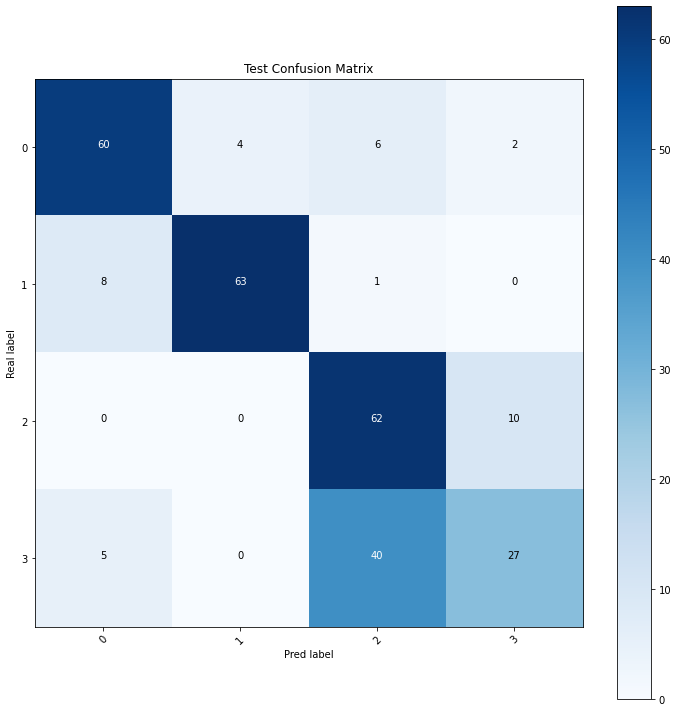

In [36]:
# load model
ld_model = Model.load(history["lastest_model_path"])
eva_test = ld_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
conf_matrix_test = np.zeros(shape=(4, 4), dtype="uint8")

real_test = teY.reshape(teY.size)
pred_test = ld_model.predict(dataset=testset)
for i in range(real_test.size):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
    conf_matrix_test[real_test[i]][pred_test[i]] += 1
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))
plot_confusion_matrix(conf_matrix_test, "Test Confusion Matrix")